## Data Import Required Libraries

### Import Required Libraries

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.functions import col, avg, count, corr, month, year, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, DoubleType, IntegerType

### Define Schema and Import Data From Dataset

In [2]:
%%capture --no-stderr

# Create a Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Define the schema
custom_schema = StructType([
    StructField("Timestamp", StringType(), nullable=True),
    StructField("FromBank", IntegerType(), nullable=True),
    StructField("FromAccount", StringType(), nullable=True),
    StructField("ToBank", IntegerType(), nullable=True),
    StructField("ToAccount", StringType(), nullable=True),
    StructField("AmountReceived", DoubleType(), nullable=True),
    StructField("ReceivingCurrency", StringType(), nullable=True),
    StructField("AmountPaid", DoubleType(), nullable=True),
    StructField("PaymentCurrency", StringType(), nullable=True),
    StructField("PaymentFormat", StringType(), nullable=True),
    StructField("IsLaundering", IntegerType(), nullable=True)
])

# Load the CSV file into a DataFrame with the specified schema
file_path = "HI-Small_Trans.csv"
df = spark.read.csv(file_path, header=True, schema=custom_schema)

# Register the DataFrame as a temporary SQL table
df.createOrReplaceTempView("transactions")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/10 00:00:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Convert string data in 'Timestamp' column to timestamp datatype

In [3]:
from pyspark.sql.functions import to_timestamp

# Assuming "timestamp_str" is the column containing the timestamp string
df = df.withColumn("Timestamp", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

# Show the DataFrame schema with the new timestamp column
df.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



### Standardize AmountReceived and AmountPaid Columns

In [4]:
import pandas as pd

# Define the exchange rates data
exchange_rates_data = [
    {"Currency": "Yen", "ExchangeRateToUSD": 0.0069},
    {"Currency": "UK Pound", "ExchangeRateToUSD": 1.234},
    {"Currency": "Australian Dollar", "ExchangeRateToUSD": 0.704},
    {"Currency": "Saudi Riyal", "ExchangeRateToUSD": 0.267},
    {"Currency": "Mexican Peso", "ExchangeRateToUSD": 0.050},
    {"Currency": "Shekel", "ExchangeRateToUSD": 0.300},
    {"Currency": "Yuan", "ExchangeRateToUSD": 0.147},
    {"Currency": "Canadian Dollar", "ExchangeRateToUSD": 0.754},
    {"Currency": "Euro", "ExchangeRateToUSD": 1.045},
    {"Currency": "Rupee", "ExchangeRateToUSD": 0.012},
    {"Currency": "Swiss Franc", "ExchangeRateToUSD": 1.028},
    {"Currency": "US Dollar", "ExchangeRateToUSD": 1.0},
    {"Currency": "Brazil Real", "ExchangeRateToUSD": 0.191},
    {"Currency": "Bitcoin", "ExchangeRateToUSD": 16386},
    {"Currency": "Ruble", "ExchangeRateToUSD": 0.013},
]

# Create the exchange_rates_df DataFrame in Pandas
exchange_rates_df = pd.DataFrame(exchange_rates_data)


In [5]:
from pyspark.sql.functions import col

exchange_rates_df = spark.createDataFrame(exchange_rates_df)

# Assuming df is your original DataFrame
# Assuming exchange_rates_df is another DataFrame with columns Currency, ExchangeRateToUSD

# Join the original DataFrame with exchange rates DataFrame for ReceivingCurrency
df_with_receiving_rate = df.join(
    exchange_rates_df.withColumnRenamed("Currency", "RecCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "ReceivingExchangeRate"),
    col("RecCurrency") == col("ReceivingCurrency")  # Assuming the original column name in df is ReceivingCurrencyOriginal
)

# Join the resulting DataFrame with exchange rates DataFrame for PaymentCurrency
df_with_rates = df_with_receiving_rate.join(
    exchange_rates_df.withColumnRenamed("Currency", "PayCurrency") \
                    .withColumnRenamed("ExchangeRateToUSD", "PaymentExchangeRate"),
    col("PayCurrency") == col("PaymentCurrency")  # Assuming the original column name in df is PaymentCurrencyOriginal
)

# Convert AmountReceived and AmountPaid to USD based on exchange rates
currency_converted_df = df_with_rates.withColumn("AmountReceivedUSD", col("AmountReceived") * col("ReceivingExchangeRate"))
currency_converted_df = currency_converted_df.withColumn("AmountPaidUSD", col("AmountPaid") * col("PaymentExchangeRate"))

# Select the relevant columns
currency_converted_df = currency_converted_df.select("Timestamp", "FromBank", "FromAccount", "ToBank", "ToAccount",
                                                     "AmountReceived", "ReceivingCurrency", "AmountReceivedUSD",
                                                     "AmountPaid", "PaymentCurrency", "AmountPaidUSD",
                                                     "PaymentFormat", "IsLaundering")

# Show the resulting DataFrame Schema
df = currency_converted_df

df.printSchema()

/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


root
 |-- Timestamp: timestamp (nullable = true)
 |-- FromBank: integer (nullable = true)
 |-- FromAccount: string (nullable = true)
 |-- ToBank: integer (nullable = true)
 |-- ToAccount: string (nullable = true)
 |-- AmountReceived: double (nullable = true)
 |-- ReceivingCurrency: string (nullable = true)
 |-- AmountReceivedUSD: double (nullable = true)
 |-- AmountPaid: double (nullable = true)
 |-- PaymentCurrency: string (nullable = true)
 |-- AmountPaidUSD: double (nullable = true)
 |-- PaymentFormat: string (nullable = true)
 |-- IsLaundering: integer (nullable = true)



## 2. Transaction Pattern Analysis

### 2.1.1 Which are the accounts with suspicious transaction spikes in the entire dataset?

In [6]:
from pyspark.sql import Window

# 1. Define the window specification
spikes_window = Window.partitionBy("FromAccount").orderBy("Timestamp").rowsBetween(-5, 5)

# 2. Calculate average over the specified window
spike_df = df.withColumn("avg", avg("AmountPaidUSD").over(spikes_window))

# 3. Identify spikes based on the condition
spike_df = spike_df.withColumn("spike", col("AmountPaidUSD") > 2 * col("avg"))

# 4. Filter and display the top 10 accounts with spikes
top_spikes_df = spike_df.filter("spike = 1") \
                       .groupBy("FromAccount") \
                       .count() \
                       .orderBy(col("count").desc()) \
                       .limit(10)

top_spikes_df.show()

# 5. Visualize spikes over time for the top 10 accounts using Seaborn/Matplotlib
top_spikes_pd = spike_df.join(top_spikes_df, "FromAccount") \
                       .filter("spike = 1") \
                       .select("Timestamp", "AmountPaidUSD", "FromAccount") \
                       .toPandas()


+-----------+-----+
|FromAccount|count|
+-----------+-----+
|  100428660|22862|
|  1004286A8|14129|
|  100428978| 2836|
|  1004286F0| 2607|
|  100428780| 2362|
|  1004289C0| 2358|
|  100428810| 2262|
|  1004287C8| 2004|
|  100428A51| 1871|
|  100428738| 1868|
+-----------+-----+



/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/opt/conda/envs/csgy-6513d-fall2023/lib/python3.9/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


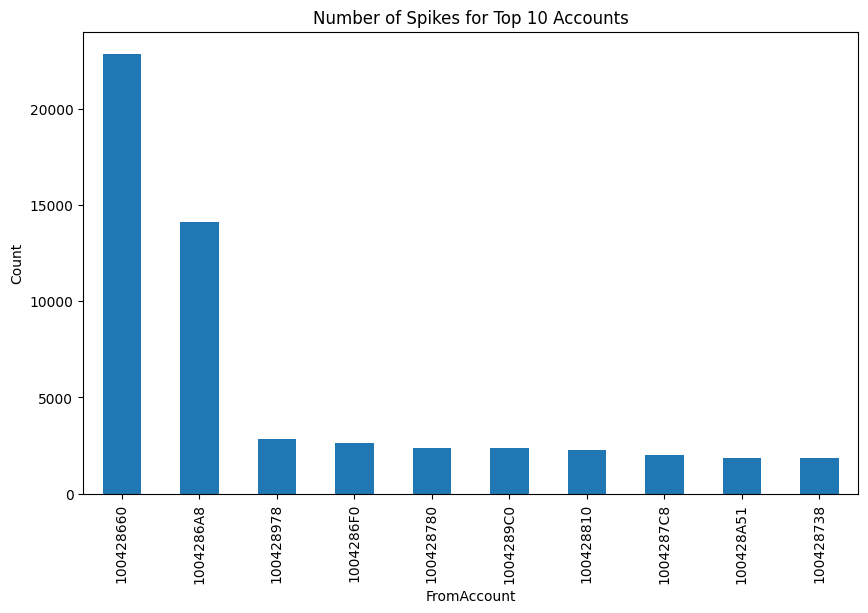

In [7]:
# Create a bar plot using Matplotlib
plt.figure(figsize=(10, 6))

# Count the occurrences of each FromAccount in top_spikes_pd
account_counts = top_spikes_pd['FromAccount'].value_counts()

# Plot the bar chart
account_counts.plot(kind='bar')

# Customize the plot
plt.title('Number of Spikes for Top 10 Accounts')
plt.xlabel('FromAccount')
plt.ylabel('Count')
plt.show()

### 2.1.2 Are these accounts part of the laundering transactions subset?

In [9]:
from pyspark.sql import functions as F

laundering_df = df.filter("IsLaundering = 1")

# Check how many accounts from top_spikes_df are in laundering_df
joined_df = top_spikes_df.join(laundering_df, "FromAccount", "inner").groupBy('FromAccount').count()

# Sort the DataFrame in descending order based on the count
joined_df = joined_df.orderBy(F.desc("count"))

# Show the result
joined_df.show()



+-----------+-----+
|FromAccount|count|
+-----------+-----+
|  100428660|  243|
|  1004286A8|  158|
|  100428978|   29|
|  100428810|   26|
|  100428738|   23|
|  100428780|   21|
|  1004286F0|   21|
|  100428A51|   18|
|  1004287C8|   16|
|  1004289C0|   13|
+-----------+-----+



### All the 10 accounts showing spike in trasactions in the dataset are part of the Laundering transactions subset

### 2.2 What are the common (Top 10) account connections in laundering transactions? (Network Plot)

In [10]:
laundering_df = df.filter("IsLaundering = 1")

# 1. Select relevant columns from the DataFrame
laundering_conns_subset = laundering_df.groupby("FromAccount", "ToAccount").count().sort(desc("count")).limit(10)

# 2. Extract data for the network plot
from_accounts = laundering_conns_subset.select("FromAccount").rdd.flatMap(lambda x: x).collect()
to_accounts = laundering_conns_subset.select("ToAccount").rdd.flatMap(lambda x: x).collect()
counts = laundering_conns_subset.select("count").rdd.flatMap(lambda x: x).collect()

# Display a table showing counts, from, and to accounts
laundering_conns_subset.show()


+-----------+---------+-----+
|FromAccount|ToAccount|count|
+-----------+---------+-----+
|  80266F880|8021353D0|   27|
|  8021353D0|80266F880|   20|
|  812A09D40|812A09CF0|   18|
|  812A09CF0|812A09D40|   15|
|  811C597B0|811C599A0|   10|
|  812A70ED0|812A70E80|   10|
|  812D22980|811C599A0|   10|
|  811C599A0|811C597B0|   10|
|  812D0C3C0|812D0C600|    9|
|  811FFF630|812D0C3C0|    8|
+-----------+---------+-----+



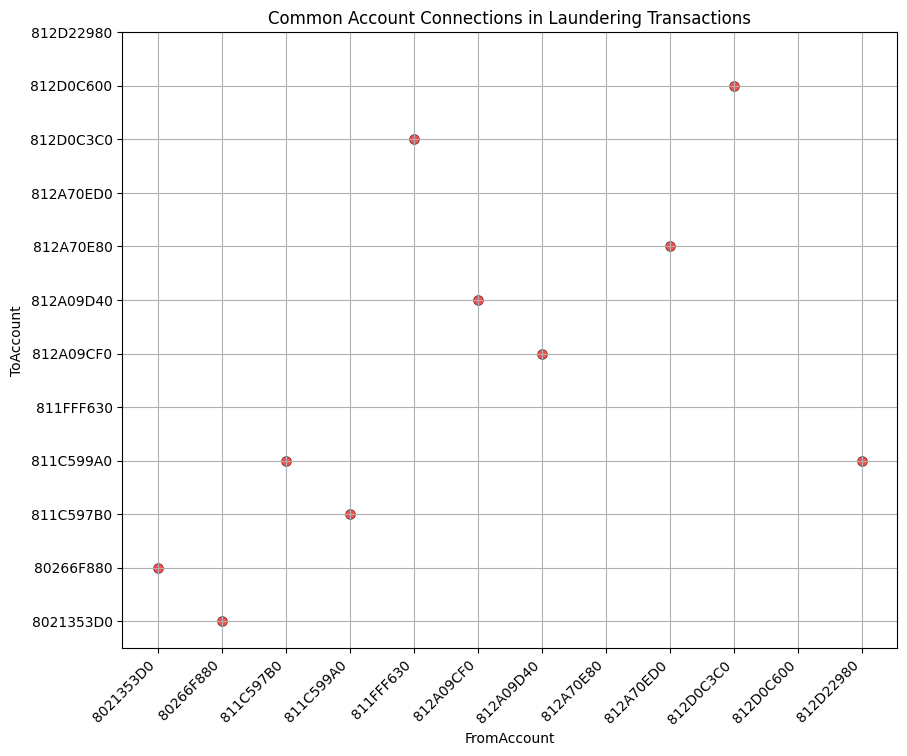

In [11]:
# Create a set of unique accounts to maintain order
unique_accounts = sorted(set(from_accounts + to_accounts))

# 3. Create a network plot using Matplotlib with ordered labels
plt.figure(figsize=(10, 8))
plt.scatter(
    [unique_accounts.index(account) for account in from_accounts],
    [unique_accounts.index(account) for account in to_accounts],
    s=50,
    edgecolors="black",
    linewidth=0.5,
    alpha=0.7,
    color='red'
)

# Customize the plot
plt.title('Common Account Connections in Laundering Transactions')
plt.xlabel('FromAccount')
plt.ylabel('ToAccount')
plt.grid(True)

# Set x-axis and y-axis labels
plt.xticks(range(len(unique_accounts)), [str(account) for account in unique_accounts], rotation=45, ha="right")
plt.yticks(range(len(unique_accounts)), [str(account) for account in unique_accounts])

# Show the plot
plt.show()


### Money is being sent to the same account and not to multiple accounts in the plot shown

### 2.3 Remitting account patterns

In [ ]:
  from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import lag, col
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming 'FromAccount', 'ToBank', and 'Timestamp' are columns in your DataFrame
# Load your data into a Spark DataFrame (replace 'your_data.csv' with your actual data)
# df = spark.read.csv("your_data.csv", header=True, inferSchema=True)

# Define the window specification
pattern_window = Window.partitionBy("FromAccount").orderBy("Timestamp")

# Calculate the previous bank using lag function
pattern_df = df.withColumn("prev_bank", lag("ToBank").over(pattern_window))

# Filter rows where the previous bank is different from the current bank
filtered_df = pattern_df.filter("prev_bank != ToBank").select("FromAccount")

# Show the result
filtered_df.show(5)

# Visualize the pattern using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df.toPandas(), x="FromAccount")
plt.title('Pattern of Changing Banks for Each Account')
plt.xlabel('FromAccount')
plt.ylabel('Count')
plt.show()


### 2.4 What are the payment formats used extensively?

+-----------+-----+
|prev_format|count|
+-----------+-----+
|        ACH| 4483|
|Credit Card|  206|
|     Cheque|  324|
|       Cash|  108|
|    Bitcoin|   56|
+-----------+-----+



/tmp/ipykernel_5893/1915787594.py:26: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="prev_format", y="count", data=format_counts.toPandas(), palette="viridis")


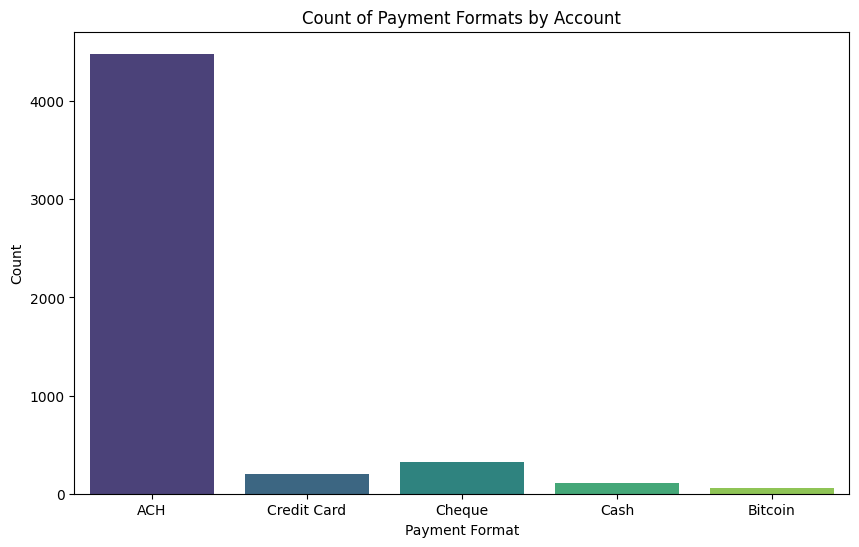

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import last, col
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'laundering_df' is the DataFrame containing the data
# Create a Spark session
spark = SparkSession.builder.appName("LaunderingAnalysis").getOrCreate()

# Define the window specification
before_window = Window.partitionBy("FromAccount").orderBy("Timestamp").rowsBetween(Window.unboundedPreceding, 0)

# Calculate the previous format using the last function
before_df = laundering_df.withColumn("prev_format", last("PaymentFormat", True).over(before_window)) \
                         .filter("prev_format is not null")

# Group by the previous format and count occurrences
format_counts = before_df.groupby("prev_format").count()

# Show the result
format_counts.show()

# Visualize using Seaborn and Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x="prev_format", y="count", data=format_counts.toPandas(), palette="viridis")
plt.title("Count of Payment Formats by Account")
plt.xlabel("Payment Format")
plt.ylabel("Count")
plt.show()


### 2.5 Payment Format Transitions

+-----------+-----------+-----+
|prev_format|next_format|count|
+-----------+-----------+-----+
|Credit Card|Credit Card|   66|
|     Cheque|       Cash|  188|
|     Cheque|Credit Card|  102|
|       Cash|Credit Card|   31|
|Credit Card|       Cash|  133|
|        ACH|     Cheque|    2|
|    Bitcoin|    Bitcoin|   56|
|     Cheque|     Cheque|   34|
|        ACH|        ACH| 4481|
|       Cash|       Cash|   68|
|Credit Card|     Cheque|    7|
|       Cash|     Cheque|    9|
+-----------+-----------+-----+



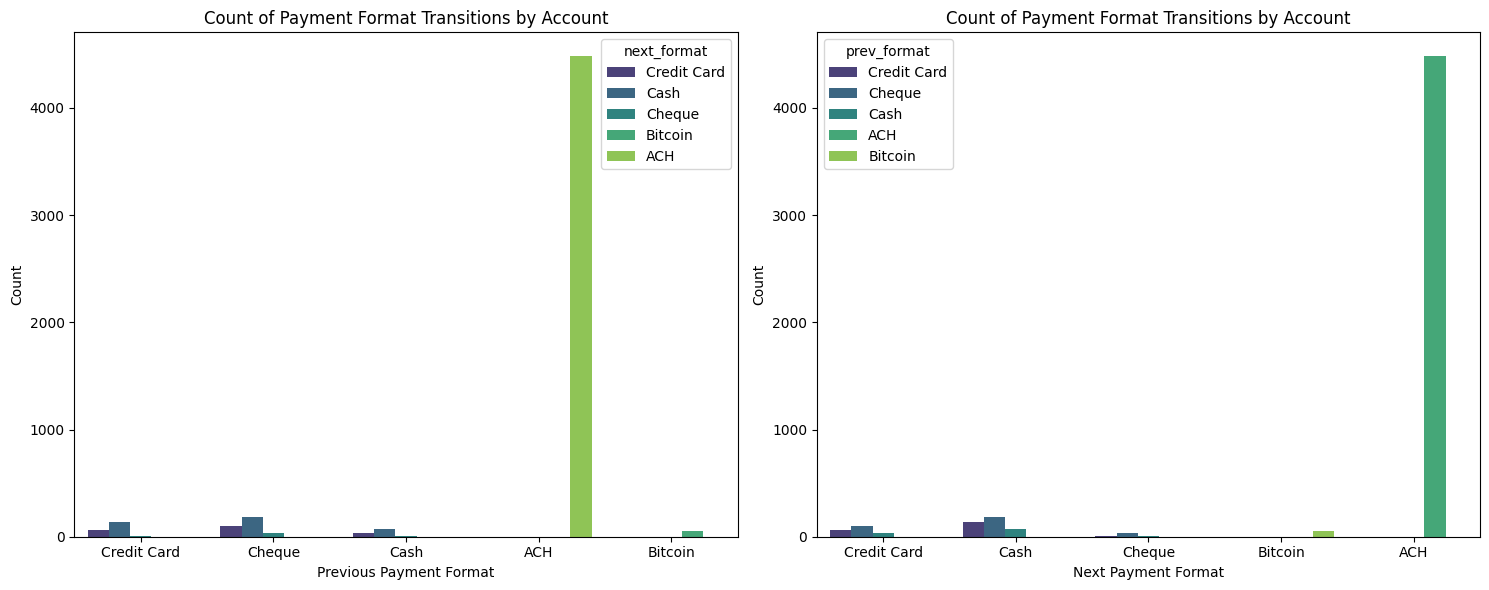

In [15]:
from pyspark.sql.functions import last, col
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'laundering_df' is the DataFrame containing the data

# Define the window specification
before_window = Window.partitionBy("FromAccount").orderBy("Timestamp").rowsBetween(Window.unboundedPreceding, 0)
after_window = Window.partitionBy("FromAccount").orderBy("Timestamp").rowsBetween(0, Window.unboundedFollowing)

# Calculate the previous and subsequent formats using the last function
full_df = laundering_df.withColumn("prev_format", last("PaymentFormat", True).over(before_window)) \
                       .withColumn("next_format", last("PaymentFormat", True).over(after_window)) \
                       .filter("prev_format is not null")

# Group by the previous and subsequent formats and count occurrences
format_counts = full_df.groupby("prev_format", "next_format").count()

# Show the result
format_counts.show()

# Visualize using Seaborn and Matplotlib
plt.figure(figsize=(15, 6))

# Bar plot for transitions from the previous format
plt.subplot(1, 2, 1)
sns.barplot(x="prev_format", y="count", hue="next_format", data=format_counts.toPandas(), palette="viridis")
plt.title("Count of Payment Format Transitions by Account")
plt.xlabel("Previous Payment Format")
plt.ylabel("Count")

# Bar plot for transitions to the next format
plt.subplot(1, 2, 2)
sns.barplot(x="next_format", y="count", hue="prev_format", data=format_counts.toPandas(), palette="viridis")
plt.title("Count of Payment Format Transitions by Account")
plt.xlabel("Next Payment Format")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

